In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,0:20,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
np.shape(tmask)

(20, 898, 398)

## Bring in grid coordinates for slice/box of interest

In [4]:
ii, ij = 450,500
ji, jj = 250,300


In [5]:
CentralSoG = [450, 500,250,300]

In [6]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [7]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [8]:
np.shape(CentralSoG)

(4,)

In [9]:
np.shape(dsfiles.time)

(192,)

In [10]:
dsfiles.diatoms

<xarray.DataArray 'diatoms' (time: 192, depth: 40, gridY: 898, gridX: 398)> Size: 11GB
dask.array<concatenate, shape=(192, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2007-01-15T12:00:00 ... 2022-12-15T12:...
  * depth    (depth) float32 160B 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 7kB 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * gridX    (gridX) int64 3kB 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Attributes:
    standard_name:  mole_concentration_of_diatoms_expressed_as_nitrogen_in_se...
    long_name:      Diatoms Concentration
    units:          mmol m-3

In [11]:
np.shape(tmask) 

(20, 898, 398)

In [12]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [13]:
newmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,20,50,50))

In [14]:
np.shape(newmask) 

(192, 20, 50, 50)

In [15]:
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)
mod_diatoms=(dsfiles.diatoms[:,0:20, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
mod_diatoms = (np.array(mod_diatoms))

mod_diatoms = np.ma.masked_where(newmask==0,mod_diatoms) ## masking where there is land

mod_flag=(dsfiles.flagellates[:,0:20, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
mod_flag = (np.array(mod_diatoms))

mod_flag = np.ma.masked_where(newmask==0,mod_flag) ## masking where there is land

In [16]:
dsfiles.close()

In [17]:
mod_diatoms = mod_diatoms.T ## transpose the variable to make it work with the Hovmoller plots

In [18]:
mod_flag = mod_flag.T

In [19]:
np.shape(mod_diatoms)

(50, 50, 20, 192)

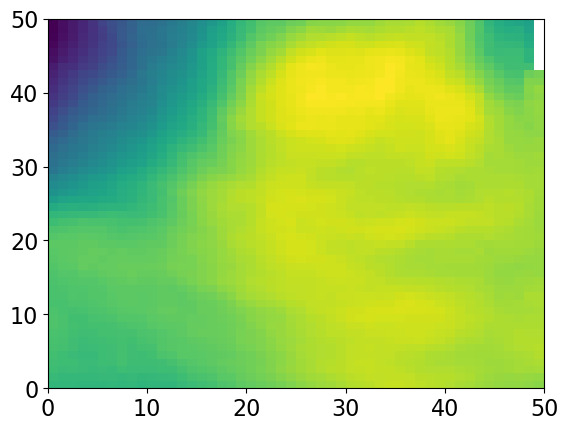

In [20]:
## Check to see what is there

plt.pcolormesh(mod_diatoms[:,:,0,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


In [21]:
mod_chl=(mod_diatoms+mod_flag)*1.8 ##Chl:N ratio of 1.8

In [22]:
mod_chl_mean=np.mean(mod_chl, axis=(0, 1,2)) ## calculate the mean across the entire slice/box 4d to 2d array and entire depth range

In [23]:
mod_chl_std=np.std(mod_chl, axis=(0, 1,2)) ## calculate the sem across the entire slice/box 4d to 2d array and entire depth range

Text(0.5, 1.0, 'Chl a at 5 m')

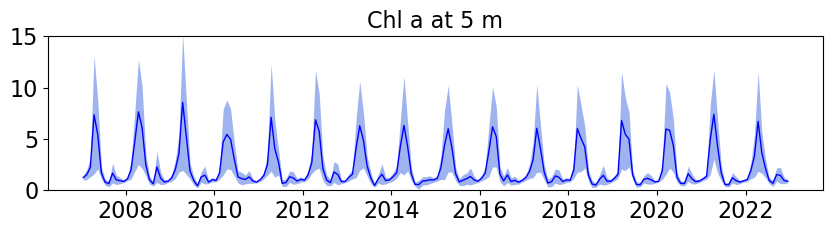

In [24]:
fig,ax=plt.subplots(1,1,figsize=(10,2))


#ax.errorbar(tt,(mod_diatoms_mean-mod_diatoms_std)*1.8,(mod_diatoms_mean+mod_diatoms_std,)*1.8)

ax.errorbar(tt, mod_chl_mean,label='',color='b',linestyle='-',linewidth=1)
ax.fill_between(tt, (mod_chl_mean-mod_chl_std), (mod_chl_mean+mod_chl_std),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0)
ax.set_ylim(0,15)
ax.set_title('Chl a at 5 m')

In [25]:
data=pd.read_csv('/ocean/ksuchy/MOAD/observe/PNW_obs_compiled.csv')

In [26]:
data.keys()

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn(nM)', 'Al (ppt)', 'Ba (ppt)',
       'Cd (ppt)', 'Co (ppt)', 'Cu (ppt)', 'Fe (ppt)', 'Ga (ppt)', 'Mn (ppt)',
       'Ni (ppt)', 'Pb (ppt)', 'Zn (ppt)', 'source'],
      dtype='object')

In [27]:
data['time']=pd.to_datetime(data['time']) 

In [28]:
data['time']

0         1930-11-07 00:00:00+00:00
1         1930-11-07 00:00:00+00:00
2         1930-11-07 00:00:00+00:00
3         1930-11-07 00:00:00+00:00
4         1930-11-07 00:00:00+00:00
                     ...           
3454506   2024-07-10 00:00:00+00:00
3454507   2024-07-10 00:00:00+00:00
3454508   2024-07-10 00:00:00+00:00
3454509   2024-07-10 00:00:00+00:00
3454510   2024-07-10 00:00:00+00:00
Name: time, Length: 3454511, dtype: datetime64[ns, UTC]

In [29]:
data['Year']=[ii.year for ii in data['time']]
data['Month']=[ii.month for ii in data['time']]
#data['YD']=et.datetimeToYD(data['time'])

In [30]:
data['Year']

0          1930
1          1930
2          1930
3          1930
4          1930
           ... 
3454506    2024
3454507    2024
3454508    2024
3454509    2024
3454510    2024
Name: Year, Length: 3454511, dtype: int64

In [31]:
data['YMO']=pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

In [32]:
data.rename(columns={'longitude (degrees_east)':'Lon','latitude (degrees_north)':'Lat'},inplace=True) 

In [33]:
data=data[~(data['Lat'] <= 49.1) & (data['Lat'] < 49.5) & (data['Lon'] <= -123.1) & (data['Lon'] > -124)] #

In [34]:
data=data[(data['Year'] >= 2007) & (data['Year'] <= 2022)]

In [35]:
data=data[(data['depth (m)'] <= 20)]

In [36]:
data

,Unnamed: 0,time,Lon,Lat,depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),...,Fe (ppt),Ga (ppt),Mn (ppt),Ni (ppt),Pb (ppt),Zn (ppt),source,Year,Month,YMO
1793861,1793861,2007-02-23 00:00:00+00:00,-123.80,49.32,6.0,6.022222,7.451517,28.596555,468.428225,23.4,...,NaN,NaN,NaN,NaN,NaN,NaN,"ios ctd profiles, ios bottle",2007,2,2007-02-01
1793862,1793862,2007-02-23 00:00:00+00:00,-123.80,49.32,15.0,15.500000,7.701650,29.256448,689.756478,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2007,2,2007-02-01
1793903,1793903,2007-02-23 00:00:00+00:00,-123.75,49.25,6.0,6.462500,7.287781,28.632383,494.253190,24.4,...,NaN,NaN,NaN,NaN,NaN,NaN,"ios ctd profiles, ios bottle",2007,2,2007-02-01
1793904,1793904,2007-02-23 00:00:00+00:00,-123.75,49.25,15.0,15.500000,7.639890,29.154455,700.416652,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2007,2,2007-02-01
1793943,1793943,2007-02-23 00:00:00+00:00,-123.55,49.16,6.0,6.211111,7.698439,29.115134,440.496209,26.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"ios ctd profiles, ios bottle",2007,2,2007-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399161,3399161,2022-10-19 00:00:00+00:00,-123.97,49.29,15.0,15.000000,10.568682,29.225896,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2022,10,2022-10-01
3399762,3399762,2022-10-20 00:00:00+00:00,-123.99,49.32,4.0,4.500000,13.131920,28.452910,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2022,10,2022-10-01
3399763,3399763,2022-10-20 00:00:00+00:00,-123.99,49.32,15.0,15.000000,10.899827,29.146828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2022,10,2022-10-01
3403884,3403884,2022-11-11 00:00:00+00:00,-123.35,49.19,6.0,6.033333,8.775578,28.768814,346.042928,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ios ctd profiles,2022,11,2022-11-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


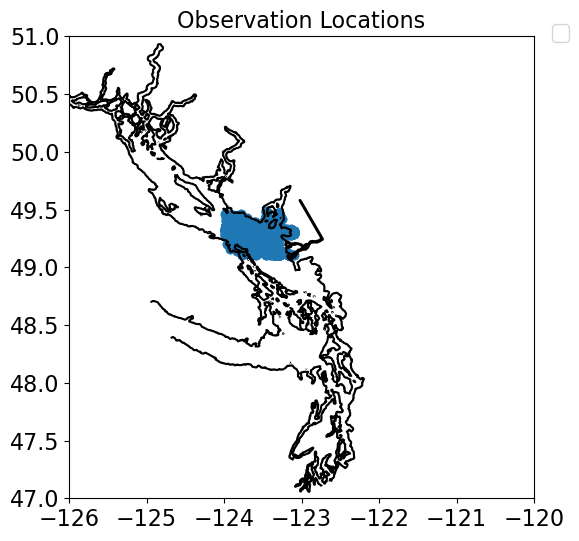

In [37]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [38]:
np.shape(data['Chl (mg m-3)'])

(3468,)

In [39]:

data=data.dropna(subset=['Chl (mg m-3)'])

In [40]:
obs_chl=data['Chl (mg m-3)'].groupby(data['YMO']).mean()

In [41]:
obs_chl

YMO
2007-02-01     6.403333
2007-04-01    10.331250
2007-06-01     2.435000
2007-10-01     2.527500
2007-11-01     0.795000
                ...    
2022-05-01     0.630000
2022-06-01     1.904286
2022-08-01     5.940000
2022-09-01     1.320000
2022-10-01     1.208750
Name: Chl (mg m-3), Length: 100, dtype: float64

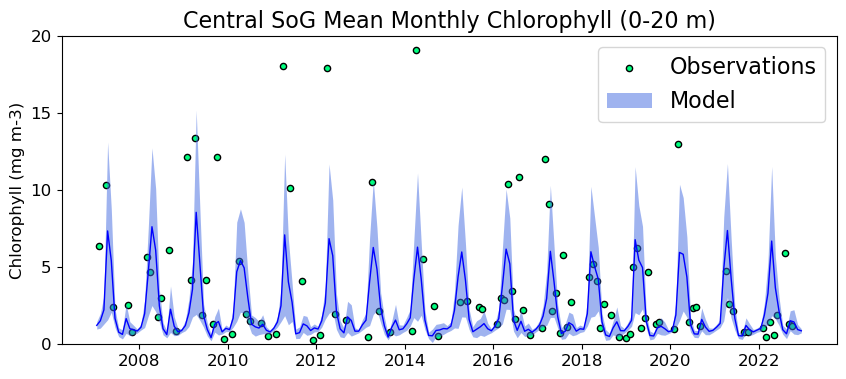

In [73]:

fig,ax=plt.subplots(1,1,figsize=(10,4))

ax.scatter(obs_chl.index,obs_chl,marker='o',color='springgreen',edgecolor='k',s=20,label='Observations')
ax.set_ylim(0,20)
ax.set_title('Central SoG Mean Monthly Chlorophyll (0-20 m)')
#ax.errorbar(tt,(mod_diatoms_mean-mod_diatoms_std)*1.8,(mod_diatoms_mean+mod_diatoms_std,)*1.8)

ax.errorbar(tt, mod_chl_mean,label='',color='b',linestyle='-',linewidth=1)
ax.fill_between(tt, (mod_chl_mean-mod_chl_std), (mod_chl_mean+mod_chl_std),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0,label='Model')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_ylabel('Chlorophyll (mg m-3)',fontsize=12)
ax.legend(frameon=True)


In [43]:
print(mod_chl_mean.min()) 
print(mod_chl_mean.max())

0.43118811896710885
8.568687789729285


In [44]:
print(obs_chl.min()) 
print(obs_chl.max())

0.25333333333333335
19.0925
